In [2]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Base model with single random categorical
Raw model - add a random categorical with 1,000 levels.  No randomization.  No NAICS

*This script takes about 2 hours on my MacBook Air*

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [5]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, \
    Concatenate, Reshape, concatenate, Flatten
import tensorflow.keras.metrics as km

In [7]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model 

In [8]:
# Imputer object for easy dataset conversion to NN friendly format
from sba_nn.sba_nn import sbnn_imputer 
from sba_nn.sba_nn.sbnn_imputer import NNImputer

## Input Data

In [9]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [10]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

## Modify Data


In [11]:
# Single random categorical
sba_loans['rand_cat'] = pd.Series(np.random.randint(0,1000, size=len(sba_loans)),
                                  index=sba_loans.index)

In [13]:
train_len = sba_loans[sba_loans['dset'] == 'train']['rand_cat'].max()
train_len

999

In [16]:
# Save data
sba_loans[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS', 'rand_cat']] \
     .to_parquet(Path(setup.temp_path).joinpath('44_DATA_rand_grp.parquet'))

In [14]:
with open(Path(setup.temp_path).joinpath('44_DATA_rand_max_encodings.pkl'), 'wb') as fout:
    pickle.dump(train_len, fout)

# Features

In [17]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [18]:
# Use analagous embedding dimensions
features_grp_all = ['rand_cat'] 
grp_emb_dim = [8]

##### Datasets for train, validation

In [20]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric].set_index('LoanNr_ChkDgt').sort_index()

In [21]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 10), y:(446848,)


In [22]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 10), y:(95604,)


In [23]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


In [25]:
X_hier = [sba_loans[['dset', 'LoanNr_ChkDgt', 'rand_cat']] \
              .set_index('LoanNr_ChkDgt').sort_index()]

In [26]:
X_hier_train = [Xn[Xn['dset'] == 'train'].drop(columns='dset') for Xn in X_hier]
X_hier_val =  [Xn[Xn['dset'] == 'val'].drop(columns='dset') for Xn in X_hier]

## Create, fit model

In [27]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         [train_len],
                                         grp_emb_dim,
                                         naics_embedding_names = ['rand_cat'],
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-29 06:26:42.078551: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-29 06:26:42.078611: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-29 06:26:42.078628: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-29 06:26:42.078675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-29 06:26:42.078694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 emb_naics_00 (Embedding)    (None, 1, 8)                 7992      ['input_naics_00[0][0]']      
                                                                                                  
 rand_cat (Flatten)          (None, 8)                    0         ['emb_naics_00[0][0]']        
                                                                                                  
 input_numeric (InputLayer)  [(None, 10)]                 0         []                        

In [29]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [30]:
this_history = this_model.fit([X_train] + X_hier_train, y_train,
                              validation_data=([X_val] + X_hier_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs,
                              callbacks=[callback])

Epoch 1/20


2024-05-29 06:26:56.315487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13963/13964 [============================>.] - ETA: 0s - loss: 0.4720 - auc: 0.3050 - auc_1: 0.6728

2024-05-29 06:30:19.080028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 225s 16ms/step - loss: 0.4720 - auc: 0.3050 - auc_1: 0.6728 - val_loss: 0.4652 - val_auc: 0.3311 - val_auc_1: 0.6929
Epoch 2/20
13964/13964 [==============================] - 184s 13ms/step - loss: 0.4656 - auc: 0.3230 - auc_1: 0.6873 - val_loss: 0.4658 - val_auc: 0.3373 - val_auc_1: 0.6983
Epoch 3/20
13964/13964 [==============================] - 192s 14ms/step - loss: 0.4640 - auc: 0.3302 - auc_1: 0.6917 - val_loss: 0.4638 - val_auc: 0.3374 - val_auc_1: 0.6987
Epoch 4/20
13964/13964 [==============================] - 194s 14ms/step - loss: 0.4629 - auc: 0.3335 - auc_1: 0.6946 - val_loss: 0.4641 - val_auc: 0.3355 - val_auc_1: 0.6973
Epoch 5/20
13964/13964 [==============================] - 198s 14ms/step - loss: 0.4621 - auc: 0.3368 - auc_1: 0.6969 - val_loss: 0.4651 - val_auc: 0.3301 - val_auc_1: 0.6944
Epoch 6/20
13964/13964 [==============================] - 198s 14ms/step - loss: 0.4616 - auc: 0.3389 - auc_1: 0.6984 - val_loss: 0.4646

In [31]:
this_history_df = sbnn_model.process_history(this_history)

In [32]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('44_REPORT_fit_history.csv'))

<Axes: >

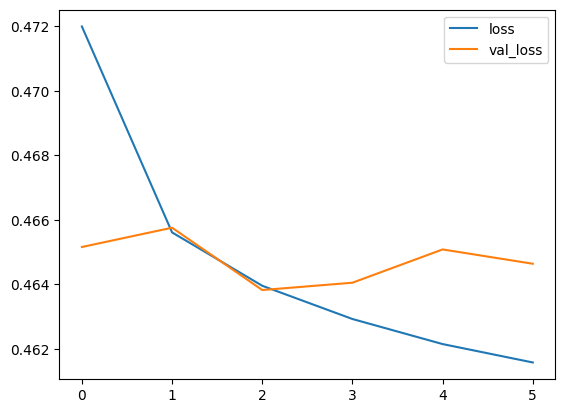

In [33]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

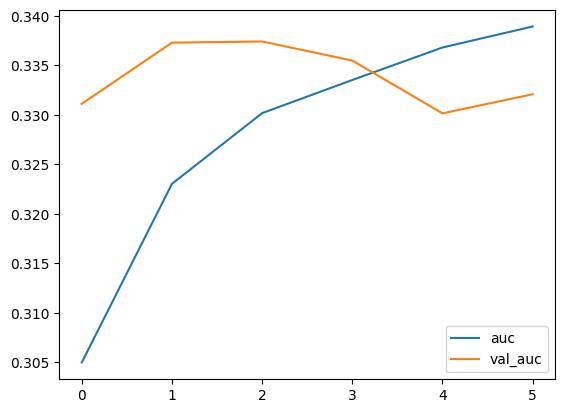

In [34]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

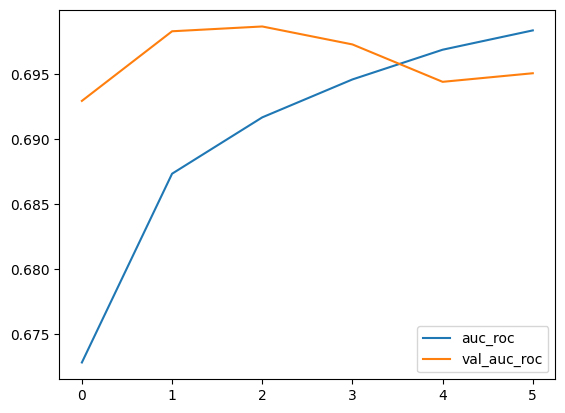

In [35]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [36]:
this_model.save(Path(setup.temp_path).joinpath('44_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [39]:
X_hier = [sba_loans[['dset', 'LoanNr_ChkDgt', 'rand_cat']] \
              .set_index('LoanNr_ChkDgt').sort_index()]

In [40]:
all_predictions = this_model.predict([X.drop(columns='dset')] +
                                     [Xn.drop(columns='dset') for Xn in X_hier])

  107/21735 [..............................] - ETA: 30s

2024-05-29 07:38:48.767069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 30s 1ms/step


In [41]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [42]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.283723
target,0.283723,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [43]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [44]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [45]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
11,0.22,0.430445
10,0.20,0.429469
12,0.24,0.428558


In [46]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.22

##### Append binary predictions to probability predictions

In [47]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [48]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.531229
1    0.468771
Name: proportion, dtype: float64

In [49]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('44_DATA_predictions.parquet'))

## Metrics

In [50]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('44_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.622243,0.427818,0.308019,0.700117,0.335895,0.700816,NaN
1,train,0.616053,0.430445,0.307507,0.717157,0.353049,0.706834,NaN
2,val,0.612652,0.426021,0.305190,0.705239,0.332132,0.695031,NaN
0,test,0.613267,0.424135,0.304057,0.700953,0.332994,0.692226,0.0
1,test,0.637161,0.434228,0.314996,0.698699,0.341772,0.714950,1.0
